### Import libraries

In [1]:
import numpy as np
import cv2 as cv2
import glob
import open3d as o3d
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Get image paths

In [ ]:
images_left = glob.glob('Stereo_calibration_images/left-*.png')
images_right = glob.glob('Stereo_calibration_images/right-*.png')
images_left.sort()
images_right.sort()
print(len(images_left))
print(len(images_right))

### Undistort and rectify based on chessboard features

In [ ]:
nb_horizontal = 9  # Number of vertical inner corners
nb_vertical = 6    # Number of horizontal inner corners

# Termination criteria (default of cv2)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)  * 36

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints_left = [] # 2d points in image plane.
imgpoints_right = [] # 2d points in image plane.

for fname_left, fname_right in zip(images_left, images_right):
    img_left = cv2.imread(fname_left)
    img_right = cv2.imread(fname_right)

    gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    # Find corners for left and right images
    ret_left, corners_left = cv2.findChessboardCorners(gray_left, (nb_vertical, nb_horizontal), cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FILTER_QUADS)
    ret_right, corners_right = cv2.findChessboardCorners(gray_right, (nb_vertical, nb_horizontal), cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FILTER_QUADS)
    
    # If found, add object points, image points (after refining them)
    if ret_left and ret_right == True:
        objpoints.append(objp)

        corners_left = cv2.cornerSubPix(gray_left, corners_left, (11,11), (-1,-1), criteria)
        imgpoints_left.append(corners_left)

        corners_right = cv2.cornerSubPix(gray_right, corners_right, (11,11), (-1,-1), criteria)
        imgpoints_right.append(corners_right)

In [ ]:
ret, left_mtx, dist_left, rvecs_left, tvecs_left = cv2.calibrateCamera(objpoints, imgpoints_left, gray_left.shape[::-1], None, None)
ret, right_mtx, dist_right, rvecs_right, tvecs_right = cv2.calibrateCamera(objpoints, imgpoints_right, gray_right.shape[::-1], None, None)

In [ ]:
stereocalibration_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
stereocalibration_flags = cv2.CALIB_FIX_INTRINSIC

ret, c_mat_l, dist1, c_mat_r, dist2, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, left_mtx, dist_left, right_mtx, dist_right, gray_right.shape[::-1], flags = stereocalibration_flags)

In [ ]:
R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(c_mat_l, dist1, c_mat_r, dist2, gray_right.shape[::-1], R, T, flags=cv2.CALIB_ZERO_DISPARITY)

In [ ]:
leftMapX, leftMapY = cv2.initUndistortRectifyMap(c_mat_l, dist1, R1, P1, gray_left.shape[::-1], cv2.CV_32FC1)

rightMapX, rightMapY = cv2.initUndistortRectifyMap(c_mat_r, dist2, R2, P2, gray_right.shape[::-1], cv2.CV_32FC1)

In [ ]:
fname_left = 'Stereo_calibration_images/left-0000.png'
leftFrame = cv2.imread(fname_left)
gray_l = cv2.cvtColor(leftFrame, cv2.COLOR_BGR2GRAY)
h_l,  w_l = gray_l.shape[:2]

fname_right = 'Stereo_calibration_images/right-0000.png'
rightFrame = cv2.imread(fname_right)
gray_r = cv2.cvtColor(rightFrame, cv2.COLOR_BGR2GRAY)
h_r,  w_r = gray_r.shape[:2]

In [ ]:
left_rect = cv2.remap(gray_l, leftMapX, leftMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
right_rect = cv2.remap(gray_r, rightMapX, rightMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

### Undistorted and rectified example 1

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (12,12))

ax[0][0].imshow(leftFrame)
ax[0][0].set_title('Original image left')

ax[0][1].imshow(left_rect, cmap='gray')
ax[0][1].set_title('Undistorted image left')


ax[1][0].imshow(rightFrame)
ax[1][0].set_title('Original image right')

ax[1][1].imshow(right_rect, cmap='gray')
ax[1][1].set_title('Undistorted image right')

plt.tight_layout()

### Undistorted and rectified example 2

In [ ]:
fname_left = './Stereo_conveyor_with_occlusions/left/1585434750_371934652_Left.png'
leftFrame = cv2.imread(fname_left)
gray_l = cv2.cvtColor(leftFrame, cv2.COLOR_BGR2GRAY)
h_l,  w_l = gray_l.shape[:2]

fname_right = './Stereo_conveyor_with_occlusions/right/1585434750_371934652_Right.png'
rightFrame = cv2.imread(fname_right)
gray_l = cv2.cvtColor(rightFrame, cv2.COLOR_BGR2GRAY)
h_l,  w_l = gray_l.shape[:2]


left_rect = cv2.remap(leftFrame, leftMapX, leftMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
right_rect = cv2.remap(rightFrame, rightMapX, rightMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

fig, ax = plt.subplots(2,2, figsize = (12,12))

ax[0][0].imshow(leftFrame)
ax[0][0].set_title('Original image left')

ax[0][1].imshow(left_rect)
ax[0][1].set_title('Undistorted image left')


ax[1][0].imshow(rightFrame)
ax[1][0].set_title('Original image right')

ax[1][1].imshow(right_rect)
ax[1][1].set_title('Undistorted image right')

plt.tight_layout()

## Depth map construction

from https://mynt-eye-d-sdk.readthedocs.io/en/v1.7.7/product/params_d1000_120.html
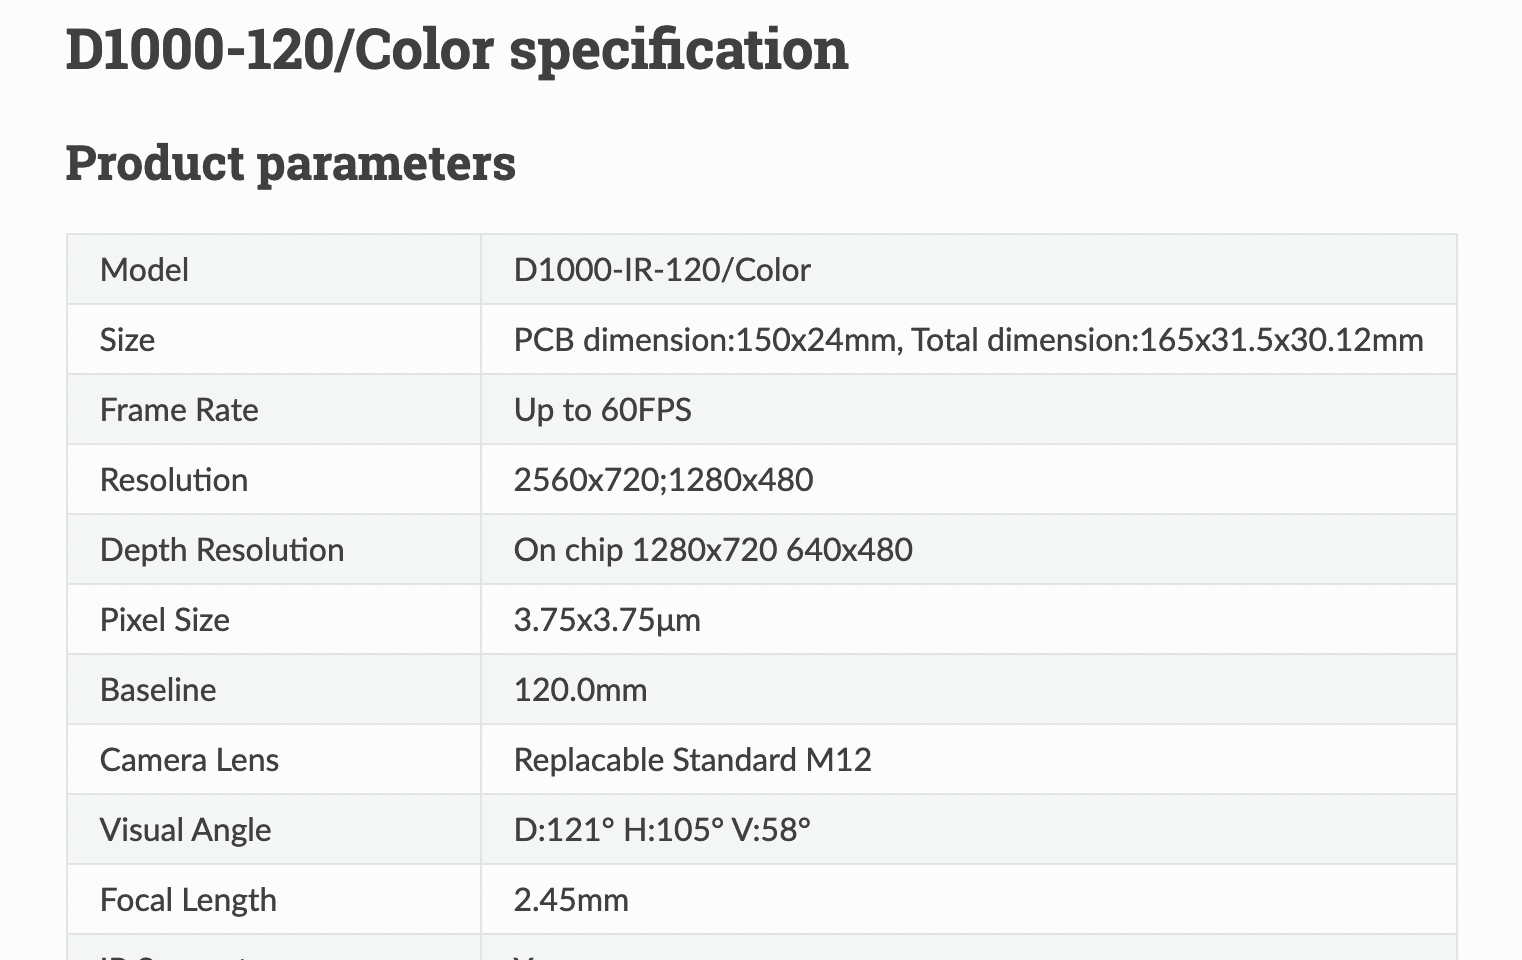

In [ ]:
fname_disp_left = './Stereo_conveyor_with_occlusions/left_undistorted/1585434750_371934652_Left.png'
imgL = cv2.imread(fname_disp_left)
leftGray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)

fname_disp_right = './Stereo_conveyor_with_occlusions/right_undistorted/1585434750_371934652_Right.png'
imgR = cv2.imread(fname_disp_right)
rightGray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (16,16))
ax[0].imshow(leftGray, 'gray')
ax[1].imshow(rightGray, 'gray')

### Disparity map for image

In [ ]:
block_size = 7
min_disp = 40
max_disp = 7 * 16
num_disp = max_disp 

stereo_2 = cv2.StereoSGBM_create(
    minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = block_size,
    uniquenessRatio = 5,
    speckleWindowSize = 5,
    speckleRange = 5,
    disp12MaxDiff = 10,
    P1 = 8 * 3 * block_size ** 2,
    P2 = 32 * 3 * block_size ** 2
)

disparity_2 = stereo_2.compute(imgR[:,::-1,:], imgL[:,::-1,:]).astype(np.float32)  / 16.0

fig, ax = plt.subplots(figsize = (16,16))
# ax[0].imshow(left_rect, 'gray')
# ax[1].imshow(right_rect, 'gray')
image = ax.imshow(disparity_2[:,::-1], cmap = 'gray')
plt.colorbar(image)

In [ ]:
print(f'Focal length in pixels: {c_mat_l[0][0]}')

### Use camera specs to calculate distance image

In [ ]:
def object_xyzd(start_x, end_x, start_y, end_y, baseline = 120, f = 703.6, centerCol = 640, centerRow = 360):
    region = disparity_2[start_x:end_x, start_y:end_y]
    mean_val = np.mean(region[region > region.min()])
    
    fig, ax = plt.subplots(figsize = (16,16))
    image = ax.imshow(region, cmap = 'gray')
    plt.colorbar(image)
    
    depth = baseline * f / mean_val
    
    x_mid = start_x + ((end_x - start_x) / 2)
    u = x_mid - centerRow
    
    y_mid = start_y + ((end_y - start_y) / 2)
    v = y_mid - centerCol
    
    x = v * depth / f
    y = u * depth / f
    
    z = np.sqrt(depth ** 2 - y ** 2 - x ** 2)
    
    return x, y, z, depth
    

Y, X, Z, object_depth = object_xyzd(300, 500, 780, 900)
print(f'''
    Distance from center row downward: {X:.2f} mm,
    Distance from center column right: {Y:.2f} mm,
    Distance from camera to center: {Z:.2f} mm,
    Depth of object in re: {object_depth:.2f} mm'''
     ) 

### Pixel depth tester

In [ ]:
baseline = 120
f = 703.65

depth = baseline * f / disparity_2

sample_pixel = [600, 500]
distance = round(depth[sample_pixel[0], sample_pixel[1]],2)
print(f'Pixel {sample_pixel} is {distance:.2f}m away from the camera')

In [ ]:
centerCol = 640
centerRow = 360
f = 703.65

xyz_im = np.zeros([depth.shape[0], depth.shape[1], 3])
print(xyz_im.shape)

for row, depth_row in enumerate(depth):
    for column, depth_val in enumerate(depth_row):
        u = row - centerRow
        v = column - centerCol
        x = u * depth_val / f
        y = v * depth_val / f
        xyz_im[row, column, :] = [x, y, z]
        

In [ ]:
print(f'{xyz_im[500,500]} in mm')

In [ ]:
left_path = glob.iglob('Stereo_conveyor_without_occlusions/left/*.png')
right_path = glob.iglob('Stereo_conveyor_without_occlusions/right/*.png')

left_path_out = 'Stereo_conveyor_without_occlusions/left_undistorted'
right_path_out = 'Stereo_conveyor_without_occlusions/right_undistorted'

from tqdm import tqdm

for left_filename, right_filename in tqdm(zip(left_path, right_path)):

    left_img = cv2.imread(left_filename)
    right_img = cv2.imread(right_filename)
    
    left_rect = cv2.remap(left_img, leftMapX, leftMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    right_rect = cv2.remap(right_img, rightMapX, rightMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    left_out = left_filename.replace('Stereo_conveyor_without_occlusions/left', left_path_out)
    right_out = right_filename.replace('Stereo_conveyor_without_occlusions/right', right_path_out)

    cv2.imwrite(left_out, left_rect)
    cv2.imwrite(right_out, right_rect)

## Kalman

In [6]:
def object_xyzd(start_x, end_x, start_y, end_y, disparity, baseline = 120, f = 703.6, centerCol = 640, centerRow = 360):
    region = disparity[start_y:end_y, start_x:end_x]
    mean_val = np.median(region[region > region.min()])
    
    depth = baseline * f / mean_val
    
    x_mid = (start_x + end_x) / 2
    u = x_mid - centerCol
    
    y_mid = (start_y + end_y) / 2
    v = -(y_mid - centerRow)
    
    x = u * depth / f
    y = v * depth / f
    
    z = np.sqrt(depth ** 2 - y ** 2 - x ** 2)
    
    return x, y, z, depth
    

### Kalman parameters and functions

In [17]:
def update(x, P, Z, H, R):
    y = Z - np.dot(H, x)
    S = np.dot(np.dot(H, P), H.T) + R
    K = np.dot(np.dot(P, H.T), np.linalg.inv(S))
    x_prime = x + np.dot(K, y)
    P_prime = np.dot((I - np.dot(K, H)), P)
    return [x_prime, P_prime]
    
def predict(x, P, F, u):    
    x_prime = np.dot(F, x) + u
    P_prime = np.dot(F, np.dot(P, F.T))
    return [x_prime, P_prime]
    
    
def restart_variables(dt = 0.27):
    # The initial state (6x1).
    x = np.array([[0],  #Position in x
                  [0],  #Velocity in x
                  [0],  #Acc in x
                  [0],  #Position in y
                  [0],  #Velocity in y
                  [0],  #Acc in y
                  [0],  #Depth pos
                  [0],  #Depth vel
                  [0]]) #Depth acc

    # The initial uncertainty (6x6).
    P = np.array([[100, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 100, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 100, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 100, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 100, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 100, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 100, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 100, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 100]])
    P1 = P

    # The external motion (6x1).
    u = np.array([[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]])

    #dt = 0.27
    v = dt
    a = 0.5 * dt**2
    # The transition matrix (6x6). 
    F = np.array([[1, v, a, 0, 0, 0, 0, 0, 0],
                  [0, 1, v, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, v, a, 0, 0, 0],
                  [0, 0, 0, 0, 1, v, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, v, a],
                  [0, 0, 0, 0, 0, 0, 0, 1, v],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1]])



    # The observation matrix (2x6).
    H = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0, 0]])

    # The measurement uncertainty.
    R = 1

    I = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1]])

    Q = np.dot(np.dot(F, P), F.T)
    print('Variables have been restarted')
    
    return x, P, P1, u, dt, v, a, F, H, R, I, Q


In [49]:
# Load the video
images_left = sorted(glob.glob('Stereo_conveyor_without_occlusions/left_undistorted/*.png'))
images_right = sorted(glob.glob('Stereo_conveyor_without_occlusions/right_undistorted/*.png'))
assert images_left, images_right

outpath = 'Final without oclussions2'


from detector import SusDetector as SD
import random

blank_image = cv2.imread(images_right[0])
detector = SD(blank_image)
detector.load_model("sus_model.h5")

detector.occlusion_area.append((6, 347, 598, 719))
detector.occlusion_area.append((1233, 1279, 4, 687))
detector.occlusion_area.append((800, 1280, 400, 720))


# Stereo matcher
block_size = 7
min_disp = 40
max_disp = 5 * 16
num_disp = max_disp 

stereo = cv2.StereoSGBM_create(
    minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = block_size,
    uniquenessRatio = 5,
    speckleWindowSize = 5,
    speckleRange = 5,
    disp12MaxDiff = 10,
    P1 = 8 * 3 * block_size ** 2,
    P2 = 32 * 3 * block_size ** 2
)

# Linear approximation of the depth
min_depth = 55.91
max_depth = 81.87
min_pixel = 210
max_pixel = 1150


labels = ["Book", "Box", "Cup"]
    
object_detected = False
object_done = True


from tqdm import tqdm
# Looping through all the frames
for fname_left, fname_right in tqdm(zip(images_left, images_right)):

    img_r = cv2.imread(fname_right)
    img_l = cv2.imread(fname_left)
    
    # Find object
    output  = detector.detect(img_r, True)  # [0] classes, [1] box coords, [2] image with box
    new_img = img_r
    
    
    
    if len(output[0]):
        
            
        mean_x = (output[1][0][0] + output[1][0][2]) / 2
        mean_y = (output[1][0][1] + output[1][0][3]) / 2
        right_x = output[1][0][2]
        left_x = output[1][0][0]
        
        width = output[1][0][2] - output[1][0][0]
        height = output[1][0][3] - output[1][0][1]
        
        startx = output[1][0][0]
        endx = output[1][0][2] 
        starty = output[1][0][1] 
        endy = output[1][0][3] 
        
        if startx > 1000 and object_done:
            if not object_detected: object_detected = True
            x, P, P1, u, dt, v, a, F, H, R, I, Q = restart_variables(0.27)
            object_done = False
        
        cv2.rectangle(new_img, (startx, starty), (endx, endy), (255, 0, 0), 1)
        
        idx = list(output[0][0]).index(max(output[0][0]))
        cv2.putText(new_img, f'{labels[idx]}', (startx,starty-10), cv2.cv2.FONT_HERSHEY_PLAIN, 1.2, (255, 0, 0), 2)
        
        
        
        # Get disparity
        disparity = stereo.compute(img_r[:,::-1,:], img_l[:,::-1,:]).astype(np.float32)  / 16.0
        Y, X, Z, object_depth = object_xyzd(startx, endx, starty, endy, disparity[:,::-1])
        new_img = cv2.cvtColor(disparity, cv2.COLOR_GRAY2BGR)

        cv2.putText(new_img, f'Depth = {object_depth:.2f}', (130,70), cv2.cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,255), 2)
        cv2.putText(new_img, f'Book {output[0][0][0] * 100 :.2f} %, Box {output[0][0][1] * 100 :.2f} %, Cup {output[0][0][2] * 100 :.2f} %', (130,90), cv2.cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,255), 2)

        # When an object is detected, perform update
        z = np.array([[int(right_x)],
                      [int(mean_y)],
                      [object_depth]])
        
        [x, P1] = update(x, P1, z, H, R)
        
        [x, P1] = predict(x, P, F, u)
        cv2.rectangle(new_img, (int(x[0]-width), int(x[3]-height/2)), (int(x[0]), int(x[3]+height/2)), (0, 0, 255), 1)
        
        if startx < 200:
            if object_detected: object_detected = False
            object_done = True
            
        
        
    else:
        if object_detected:
            [x, P1] = predict(x, P, F, u)
            cv2.rectangle(new_img, (int(x[0]-width), int(x[3]-height/2)), (int(x[0]), int(x[3]+height/2)), (0, 0, 255), 1)
            cv2.putText(new_img, f'Depth = {x[6][0]:.2f}', (130,70), cv2.cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,255), 2)
            
    
    
    Show the frame
    print(output)
    cv2.imshow('Frame', new_img)
    cv2.waitKey(40)
    
    k = cv2.waitKey(40) & 0xFF
    if k == 27:
        cv2.destroyAllWindows()
        break

    
cv2.destroyAllWindows()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 4, 4, 32)         0         
 g2D)                                                            
                                                                 
 flatten_38 (Flatten)        (None, 512)               0         
                                                                 
 dense_76 (Dense)            (None, 64)                32832     
                                                                 
 dense_77 (Dense)            (None, 3)                 195       
                                                                 
Total params: 33,923
Trainable params: 33,923
Non-trainable params: 0
_________________________________________________

87it [00:54,  1.60it/s]

Variables have been restarted


308it [03:12,  1.66it/s]

Variables have been restarted


483it [05:05,  1.50it/s]

Variables have been restarted


653it [06:53,  1.47it/s]

Variables have been restarted


665it [07:01,  1.55it/s]

Variables have been restarted


891it [09:24,  1.65it/s]

Variables have been restarted


1089it [11:29,  1.71it/s]

Variables have been restarted


1312it [13:51,  1.60it/s]

Variables have been restarted


1567it [16:34,  1.58it/s]


In [51]:
images = sorted(glob.glob('Final with oclussions/*.png'))
assert images
video_name = 'with oclussions final.mp4'


frame = cv2.imread(images[0])

# setting the frame width, height width
# the width, height of first image
height, width, layers = frame.shape  
frame_size = (width,height)
print(frame_size)

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 20, frame_size)

from tqdm import tqdm
# Appending the images to the video one by one
for image in tqdm(images): 
    frame = cv2.imread(image)
    video.write(frame)
    
video.release()

(1280, 720)


100%|██████████| 1453/1453 [01:52<00:00, 12.95it/s]
